In [4]:
!pip install contractions
!pip install textblob
!pip install emoji
!pip install regex
!pip install demoji
!pip install pyLDAvis==3.4.1
!pip install tdqm

!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# !pip install pandas==2.2.0
print(pd.__version__)

2.2.1


In [5]:
#try 2.1.2 for pyLDAvis
# 2.0.0
# 1.5.1

!pip install pyLDAvis==3.4.1

Defaulting to user installation because normal site-packages is not writeable


In [161]:
print(sklearn.__version__) #1.4.1.post1

1.4.1.post1


In [5]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.figure_factory as ff

import re
import emoji 
import demoji
import contractions
from tqdm import tqdm

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import pyLDAvis
pyLDAvis.enable_notebook()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrtcloud-8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mrtcloud-8/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
#Read and convert csv files to data frames
before_war = pd.read_csv("before_war.csv")
war_and_after = pd.read_csv("war_and_afterwards.csv")

In [28]:
'''
This function removes stopwords, tokenizes the text, and performs other basic text processing.
I used the emoji and demoji libraries to extract the meaning of the emojis to achieve a more accurate sentiment score.
The cleaned text will be stored in another column called cleaned_text.
I also used Vader to calculate the sentiment score of each tweet (-1 = negative, 1 = positive)
# '''

from tqdm import tqdm  # Import tqdm library

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Set up stopwords
stop_words = set(stopwords.words('english'))

#Clean the text data
def clean_text(text):
    #Remove any links via re
    text = re.sub(r'http\S+', ' ', text)

    #Account for contractions like I've
#     text = contractions.fix(text)

    #Convert emojis to text
    text = emoji.demojize(text, delimiters=(" "," ")) 

    #Only accept alphabetical chars after processing emojis
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    #Tokenize text and make everything lowercase
    tokens = word_tokenize(text.lower())

    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

tqdm.pandas()

#Clean the 'text' column and save cleaned text as 'cleaned_text'
# before_war['cleaned_text'] = before_war.apply(clean_text, axis=1)
# war_and_after['cleaned_text'] = war_and_after.apply(clean_text, axis=1)
# Clean the 'text' column and save cleaned text as 'cleaned_text'
before_war['cleaned_text'] = before_war['text'].progress_apply(clean_text)
war_and_after['cleaned_text'] = war_and_after['text'].progress_apply(clean_text)
                                            
#Apply VADER sentiment analysis to the 'text' columns in both datasets
# before_war['sentiment_score'] = before_war['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
before_war['sentiment_score'] = before_war['cleaned_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])
war_and_after['sentiment_score'] = war_and_after['cleaned_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8268526/8268526 [21:54<00:00, 6292.11it/s]


In [44]:

# #pickle files
# before_war_cleaned = before_war
# war_and_after_cleaned = war_and_after
# with open('before_war_cleaned.pkl', 'wb') as f:
#     pickle.dump(before_war_cleaned, f)
    
# with open('war_and_after_cleaned.pkl', 'wb') as f:
#     pickle.dump(war_and_after_cleaned, f)

with open('before_war_cleaned.pkl', 'rb') as f:
    before_war = pickle.load(f)
    print(before_war.shape)

with open('war_and_after_cleaned.pkl', 'rb') as f:
    war_and_after = pickle.load(f)
    print(war_and_after.shape)



(835142, 6)
(8268526, 6)


In [ ]:
#Frequency of Posts by Year-Month

ym2 = before_war['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym2.index, y = ym2.values, color='green') # plot the line chart using seaborn
plt.title('Distribution of Tweets Before War', fontsize=15)

ym = war_and_after['date'].value_counts().sort_index() # get the counts for each year-month and sort them
plt.figure(figsize=(20,6))
sns.lineplot(x=ym.index, y = ym.values, color='green') # plot the line chart using seaborn
plt.title('Year-Month distribution of tweets', fontsize=15)

In [31]:
#Get TF-IDF of before_war
#Convert text into matrix of token counts.
before_war_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 10,
                                ngram_range=(2,4))

#Tokenize the text data and conver tot sparse matrix representation 
#(doc index, token index in vocab)  count of token in doc  
before_war_tfidf = before_war_vect.fit_transform(before_war['cleaned_text'])
print(before_war_tfidf.shape)

(835142, 5000)


In [32]:
#Convert text into matrix of token counts.
war_and_after_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=10000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.95,
                                min_df = 10,
                                ngram_range=(2,4))
#Tokenize the text data and convert to sparse matrix representation 
#(doc index, token index in vocab)  count of token in doc  
war_and_after_tfidf = war_and_after_vect.fit_transform(war_and_after['cleaned_text'])
print(war_and_after_tfidf.shape)

(8268526, 10000)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


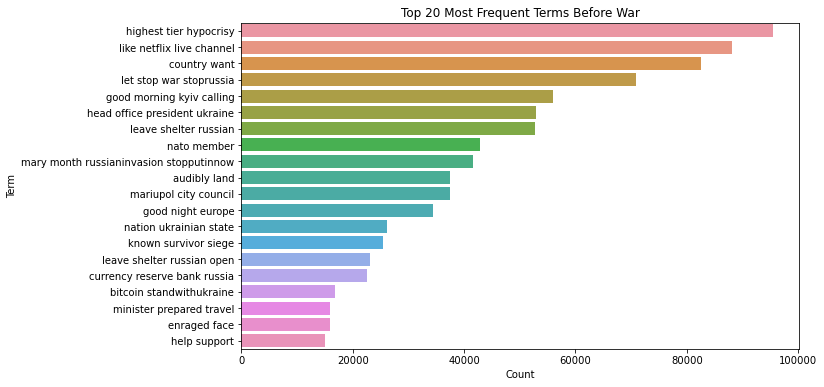

In [58]:
#Most frequent words in before_war

# Combine the counts of each token across all tweets
token_counts_before_war = np.array(before_war_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts_before_war)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab_before_war = before_war_vect.get_feature_names_out()

# Get the most frequent terms and their counts
term_freq_before_war = [(vocab[i], token_counts_before_war[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(term_freq_before_war, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms Before War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


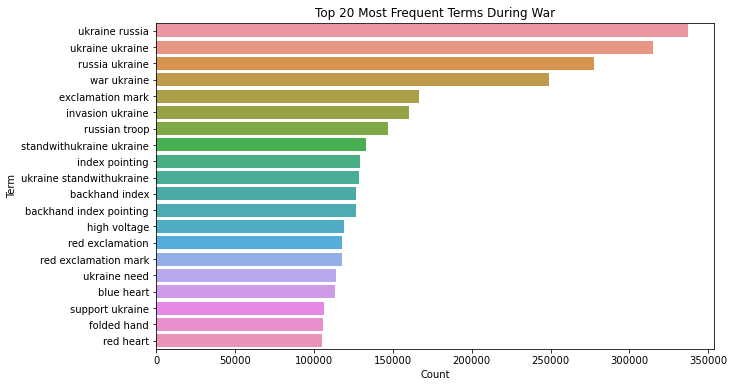

In [61]:
#Most frequent words in after_war

# Combine the counts of each token across all tweets
token_counts_war_and_after = np.array(war_and_after_tfidf.sum(axis=0))[0]

# Get indices of sorted token counts 
sorted_indices = np.argsort(token_counts_war_and_after)[::-1]

# Get unique terms/token from extracted text (vocab)from CountVectorizer
vocab = war_and_after_vect.get_feature_names_out()

# Get the most frequent terms and their counts
term_freq_war_and_after = [(vocab[i], token_counts_war_and_after[i]) for i in sorted_indices]

# Convert the most frequent terms to a DataFrame for visualization
most_frequent_df = pd.DataFrame(term_freq_war_and_after, columns=['Term', 'Count'])


# Plot the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Term', data=most_frequent_df.head(20))  # Adjust the number to display more or fewer terms
plt.title('Top 20 Most Frequent Terms During War')
plt.xlabel('Count')
plt.ylabel('Term')
plt.show()


In [10]:
#Pickle before_war LDAs
# with open('before_war_lda.pkl', 'wb') as f:
#     pickle.dump(before_war_lda, f)
# with open('before_war_lda2.pkl', 'wb') as f:
#     pickle.dump(before_war_lda2, f)

#Pickle war_and_after LDA
# with open('before_war_lda.pkl', 'wb') as f:
#     pickle.dump(before_war_lda, f)
# with open('before_war_lda2.pkl', 'wb') as f:
#     pickle.dump(before_war_lda2, f)


#Pickle war_and_after LDAs
# with open('before_war_vect.pkl', 'wb') as f:
#     pickle.dump(before_war_vect, f)
# with open('war_and_after_vect.pkl', 'wb') as f:
#     pickle.dump(war_and_after_vect, f)

# with open('before_war_tfidf.pkl', 'wb') as f:
#     pickle.dump(before_war_tfidf, f)
# with open('war_and_after_tfidf.pkl', 'wb') as f:
#     pickle.dump(war_and_after_tfidf, f)

# with open('before_war_sample.pkl', 'wb') as f:
#     pickle.dump(before_war_sample, f)
# with open('war_and_after_sample.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample, f)


#read before_war_lda
# with open('before_war_lda.pkl', 'rb') as f:
#     before_war_lda = pickle.load(f)
# with open('before_war_lda2.pkl', 'rb') as f:
#     before_war_lda2 = pickle.load(f)

# #Read pickled after_war_LDAs
# with open('war_and_after_lda.pkl', 'rb') as f:
#     war_and_after_lda = pickle.load(f)


#Read pickled tfidfs
with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
    print(before_war_tfidf.shape)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)
    print(war_and_after_tfidf.shape)

#read pickled vects
with open('before_war_vect.pkl', 'rb') as f:
    before_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)

with open('before_war_dict.pkl', 'rb') as f:
    before_war_dict = pickle.load(f)
with open('war_and_after_dict.pkl', 'rb') as f:
    war_and_after_dict = pickle.load(f)

# with open('before_war_titles.pkl', 'rb') as f:
#     before_war_titles = pickle.load(f)
# with open('war_and_after_titles.pkl', 'rb') as f:
#     war_and_after_titles = pickle.load(f)


# with open('before_war_corpora.pkl', 'rb') as f:
#     before_war_corpora = pickle.load(f)
# with open('war_and_after_corpora.pkl', 'rb') as f:
#     war_and_after_corpora = pickle.load(f)

(173585, 5000)
(1262618, 5000)


# Data Stratification 

In [48]:
#make smaller datasets
#stratified random sampling for before_war dataset
before_war_sample = before_war.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.5, random_state=42))

# #stratified random sampling for war_and_after dataset
war_and_after_sample = war_and_after.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.2, random_state=42))


/tmp/ipykernel_148019/2960637280.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  before_war_sample = before_war.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.5, random_state=42))
/tmp/ipykernel_148019/2960637280.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  war_and_after_sample = war_and_after.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.2, random_state=42))


In [50]:
# #stratified random sampling for war_and_after dataset
print("before_war_sample: ", before_war_sample.shape)
print("war_and_after_sample: ", war_and_after_sample.shape)

before_war_sample:  (173585, 6)
war_and_after_sample:  (1262618, 6)


In [ ]:
war_and_after_sample = war_and_after.groupby('cleaned_text').apply(lambda x: x.sample(frac=0.1, random_state=42))
war_and_after_sample.shape

# SKlearn

In [14]:
before_war_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 5,
                                ngram_range=(2,4))
before_war_tfidf = before_war_vect.fit_transform(before_war_sample['cleaned_text'])
print(before_war_tfidf.shape)

war_and_after_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.80,
                                min_df = 15,
                                ngram_range=(2,4))

war_and_after_tfidf = war_and_after_vect.fit_transform(war_and_after_sample['cleaned_text'])
print(war_and_after_tfidf.shape)

(173585, 5000)
(1262618, 5000)


In [13]:


war_and_after_vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=5000,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.85,
                                min_df = 5,
                                ngram_range=(2,4))

war_and_after_tfidf = war_and_after_vect.fit_transform(war_and_after_sample['cleaned_text'])
print(war_and_after_tfidf.shape)

(173585, 5000)
(1262618, 5000)


In [39]:
#initial: max_iter = 80, n_components = 11
before_war_lda = LatentDirichletAllocation(n_components=11,
                                   max_iter=95,
                                   learning_method='online',
                                   random_state = 42)


before_war_lda.fit(before_war_tfidf)

LatentDirichletAllocation(learning_method='online', max_iter=90,
                          random_state=42)

In [ ]:
war_and_after_lda = LatentDirichletAllocation(n_components=15,
                                   max_iter=500,
                                   learning_method='online',
                                   random_state = 42)


war_and_after_lda.fit(war_and_after_tfidf)

In [10]:
#get top 10 words from the 10 clusters
n_top_words = 10
tf_feature_names = before_war_vect.get_feature_names_out()

topics = dict()
for topic_idx, topic in enumerate(before_war_lda.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
twitter com | russian troop | eastern ukraine | russia ukraine | joining nato | russia invades | ukraine twitter | ukraine twitter com | ukrainian border | border russia
Topic #1:
com news | vladimir putin | going invade | russian military | ukraine russia | news world | russia going | ukraine tension | russia going invade | nato membership
Topic #2:
ukraine nato | ukraine border | russia troop | nato ally | russian troop | troop near ukraine | support ukraine | look like | nato expansion | invaded ukraine
Topic #3:
russian troop | border ukraine | troop border | ukraine crisis | sending troop | com world | nato country | troop border ukraine | russia nato | russian troop border
Topic #4:
war ukraine | russian troop | russia want | start war | face tear | tear joy | face tear joy | ukraine troop | mfa russia | amp nato
Topic #5:
invade ukraine | russia invade | russia invade ukraine | invasion ukraine | russian invasion | ukraine war | russia ukraine | eastern europe | cold w

In [31]:
import pyLDAvis.lda_model

#at max_iter = 85
vocab_before_war = list(before_war_vect.get_feature_names_out())
#Read pickled after_war_LDAs
visual = pyLDAvis.lda_model.prepare(before_war_lda, before_war_tfidf, before_war_vect, vocab=vocab_before_war )
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.199742  0.095167       1        1  10.421083
10    -0.070658  0.324487       2        1   9.702364
1      0.102359  0.124575       3        1   9.494425
9      0.034883 -0.010142       4        1   9.374094
8     -0.032776  0.077267       5        1   9.362572
7      0.115190 -0.238588       6        1   9.302718
4      0.115210 -0.134995       7        1   8.977005
2      0.181307 -0.052518       8        1   8.863798
6     -0.157629  0.022526       9        1   8.432156
3     -0.298532 -0.099347      10        1   8.325698
5     -0.189097 -0.108430      11        1   7.744088, topic_info=                                        Term         Freq         Total  \
4114               tell truth putin invasion  4832.000000   4832.000000   
4115                           term security  3215.000000   3215.000000   
3849        standwithukraine ukraine kharkiv  3573.000000   3573.000000   
549               changed lock house invited  3934.000000   3934.000000   
4233                           toy ukrainian  8938.000000   8938.000000   
...                                      ...          ...           ...   
2997                            putin regime   381.867402    961.193461   
4819                               war rally   353.418691   1317.110226   
1575  grow voice unitedblue strongertogether   362.317252   3409.897064   
549               changed lock house invited   274.600679   3934.093325   
3169           repetition slaughter atrocity   187.082715  10634.953397   

     Category  logprob  loglift  
4114  Default  30.0000  30.0000  
4115  Default  29.0000  29.0000  
3849  Default  28.0000  28.0000  
549   Default  27.0000  27.0000  
4233  Default  26.0000  26.0000  
...       ...      ...      ...  
2997  Topic11  -4.2864   1.6351  
4819  Topic11  -4.3639   1.2427  
1575  Topic11  -4.3390   0.3163  
549   Topic11  -4.6162  -0.1039  
3169  Topic11  -5.0000  -1.4821  

[449 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
25        3  0.989756                  aching heart add
40        9  0.995640             active war zone stand
93        5  0.997473       airbnb help ukraine refugee
109       4  0.995612    ally preparing reinvade tigray
124       2  0.995977                  amp ensure peace
...     ...       ...                               ...
4972      5  0.995914                      yellow heart
4973      5  0.996691                 yellow heart blue
4981      6  0.996748       yulia zdanovska europe best
4994      3  0.996103  zelenskyyua person kyiv european
4995      3  0.991086                zelenskyyua signed

[455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 2, 10, 9, 8, 5, 3, 7, 4, 6])

In [ ]:
war_and_after_vect.fit(war_and_after_sample['cleaned_text'])
vocab_war_and_after = list(war_and_after_vect.get_feature_names_out())
#Read pickled after_war_LDAs

# with open('before_war_doc_topic_dist.pkl', 'rb') as f:
#     before_war_doc_topic_dist = pickle.load(f)
import pyLDAvis.lda_model

visual_after = pyLDAvis.lda_model.prepare(war_and_after_lda, war_and_after_tfidf, war_and_after_vect, vocab=vocab_war_and_after )
visual_after


## Get Hyperparameters

### Before war

In [ ]:
# LOOK AT TESTER PY
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 60
step_size = 5
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_topics, max_topics, step_size)

# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

#Copilot told me most optimal number would be 60(?)

In [ ]:
#LOOK AT  LDAMODELS.ipynb
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=15, max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 50
max_iter = 200
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(before_war_tfidf, min_iter, max_iter, step_size)

# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Before War: Log-Likelihood vs. Number of Topics')
plt.grid(True)

## During and After War


Calculating Log-Likelihoods: 100%|███████████| 11/11 [2:40:21<00:00, 874.66s/it]


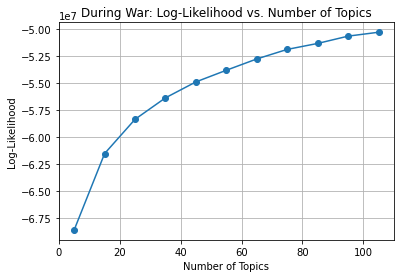

In [80]:
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_topics in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_topics = 5
max_topics = 100
step_size = 10
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_topics, max_topics, step_size)

plt.figure(figsize=(12, 10))  
# Plot log-likelihoods
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Topics')
plt.grid(True)
plt.show()

In [ ]:
#Number of iterations
#Execution for this code is in Tester.ipynb
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


# Define a function to train LDA models and calculate log-likelihood
def calculate_log_likelihood(data, min_topics, max_topics, step_size):
    log_likelihoods = []
    topic_range = range(min_topics, max_topics + step_size, step_size)
    
    # Wrap the loop with tqdm to display a progress bar
    for num_iter in tqdm(topic_range, desc='Calculating Log-Likelihoods'):
        lda_model = LatentDirichletAllocation( max_iter=num_iter, random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihoods.append(log_likelihood)
    
    return topic_range, log_likelihoods

# Calculate log-likelihoods
min_iter= 100
max_iter = 500
step_size = 200
topic_range, log_likelihoods = calculate_log_likelihood(war_and_after_tfidf, min_iter, max_iter, step_size)

# Plot log-likelihoods
plt.figure(figsize=(12, 10))  
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Log-Likelihood')
plt.title('During War: Log-Likelihood vs. Number of Iterations')
plt.grid(True)

Calculating Log-Likelihoods:   0%|                        | 0/3 [00:00<?, ?it/s]

In [142]:
n_top_words = 5W
tf_feature_names = before_war_vect.get_feature_names()

topics = dict()
for topic_idx, topic in enumerate(before_war_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
russia invade | twitter com | invasion ukraine | russian invasion | sending troop
Topic #1:
ukraine border | troop ukraine | russian troop | troop ukraine border | near ukraine
Topic #2:
united state | russian troop | world war | russia ukraine | ukraine nato
Topic #3:
war ukraine | ukraine russia | border ukraine | troop border | russian troop
Topic #4:
invade ukraine | russia invade ukraine | ukraine nato | join nato | ukraine join
Topic #5:
russia ukraine | war russia | com news | ukraine war | ukraine crisis


In [ ]:
#LDA topic modeling on war_and_after

#10 topics
# war_and_after_lda = LatentDirichletAllocation(n_components=10,
#                                    max_iter=200,
#                                    learning_method='online',
#                                    random_state = 0)
# war_and_after_lda.fit(war_and_after_tfidf)

from tqdm import tqdm

# # Initialize LDA model
# war_and_after_lda = LatentDirichletAllocation(n_components=10,
#                                                max_iter=200,
#                                                learning_method='online',
#                                                random_state=0)

# # Initialize progress bar
# progress_bar = tqdm(total=war_and_after_lda.max_iter)

# # Fit LDA model with progress bar
# for iteration in range(war_and_after_lda.max_iter):
#     war_and_after_lda.partial_fit(war_and_after_tfidf)
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()


#For 6 topics
# war_and_after_lda = LatentDirichletAllocation(n_components=6,
#                                    max_iter=200,
#                                    learning_method='online',
#                                    random_state = 0)
# war_and_after_lda.fit(war_and_after_tfidf)

# Initialize LDA model
war_and_after_lda2 = LatentDirichletAllocation(n_components=6,
                                               max_iter=200,
                                               learning_method='online',
                                               random_state=0)

# Initialize progress bar
progress_bar = tqdm(total=war_and_after_lda2.max_iter)

# Fit LDA model with progress bar
for iteration in range(war_and_after_lda2.max_iter):
    war_and_after_lda2.partial_fit(war_and_after_tfidf)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

In [46]:
n_top_words = 5
tf_feature_names = war_and_after_vect.get_feature_names()
print("After War 10 Clusters: ")
topics = dict()
for topic_idx, topic in enumerate(war_and_after_lda2.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % topic_idx)
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

# Gensim

In [69]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
import random

# Function to generate n-grams
def generate_ngrams(texts):
    n = random.choice([3, 4])  # Choose randomly between 3 and 4
    # Create phrases (trigram or quadgram)
    phrases = Phrases(texts, min_count=1, threshold=n)
    ngram = Phraser(phrases)

    # Apply phrases to texts
    return [ngram[text] for text in texts]

# Sampled datasets
before_war_titles = before_war_sample['cleaned_text'].apply(lambda x: x.split())
war_and_after_titles = war_and_after_sample['cleaned_text'].apply(lambda x: x.split())

# Generate n-grams for sampled datasets
before_war_ngrams = generate_ngrams(before_war_titles)
war_and_after_ngrams = generate_ngrams(war_and_after_titles)

# Create dictionaries for sampled datasets
before_war_dict = Dictionary(before_war_ngrams)
war_and_after_dict = Dictionary(war_and_after_ngrams)

# Filter out tokens based on frequency
before_war_dict.filter_extremes(no_below=10, no_above=0.85)
war_and_after_dict.filter_extremes(no_below=10, no_above=0.85)

# Convert text data to bag-of-words representation (corpora)
before_war_corpora = [before_war_dict.doc2bow(doc) for doc in before_war_ngrams]
war_and_after_corpora = [war_and_after_dict.doc2bow(doc) for doc in war_and_after_ngrams]


# with open('before_war_dict.pkl', 'wb') as f:
#     pickle.dump(before_war_dict, f)
# with open('war_and_after_dict.pkl', 'wb') as f:
#     pickle.dump(war_and_after_dict, f)


# with open('before_war_corpora.pkl', 'wb') as f:
#     pickle.dump(before_war_corpora, f)
# with open('war_and_after_corpora.pkl', 'wb') as f:
#     pickle.dump(war_and_after_corpora, f)

In [71]:
# with open('before_war_dict.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_titles, f)
# with open('war_and_after_dict.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_titles, f)


# with open('before_war_corpora.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_corpora, f)
# with open('war_and_after_corpora.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_corpora, f)

# with open('before_war_titles.pkl', 'wb') as f:
#     pickle.dump(before_war_sample_titles, f)
# with open('war_and_after_titles.pkl', 'wb') as f:
#     pickle.dump(war_and_after_sample_titles, f)

print("before_war corpora ", len(before_war_corpora))
print("war_and_after corpora: ", len(war_and_after_corpora))

before_war corpora  173585
war_and_after corpora:  1262618


Progress:   0%|                                          | 0/15 [05:17<?, ?it/s]
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/mrtcloud-8/.local/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
Progress: 100%|███████████████████████████████████| 8/8 [05:07<00:00, 38.41s/it]


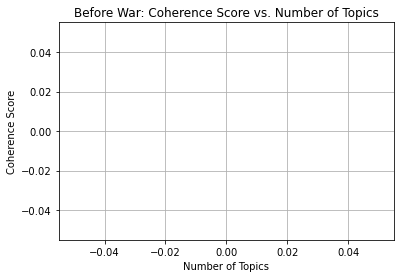

In [72]:
from tqdm import tqdm  # Import tqdm for progress bar
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Define a range of values for the number of topics
min_topics = 5
max_topics = 40
step_size = 5
topic_range = range(min_topics, max_topics + step_size, step_size)

# Initialize lists to store metric scores
coherence_scores = []

# Initialize tqdm progress bar
progress_bar = tqdm(total=len(topic_range), desc='Progress', position=0)

# Iterate over the range of topic values
for num_topics in topic_range:
    # Train LDA model
    before_war_lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=num_topics, random_state=42)
    # Compute coherence score
    coherence_model = CoherenceModel(model=before_war_lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Append coherence score to list
    coherence_scores.append(coherence_score)
    
    # Update progress bar
    progress_bar.update(1)

# Close tqdm progress bar
progress_bar.close()

# Plot the coherence scores
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()


#based on this, it appears that the most ideal number of topics is 10 

In [73]:
# Assuming that corpus is your bag of words corpus and id2word is your dictionary
coherence_scores = []
passes_range = range(50, 200, 10)  # Adjust the range as needed

progress_bar = tqdm(total=len(passes_range), desc='Progress', position=0)
for passes in passes_range:
    print("entering")
    lda_model = LdaModel(corpus=before_war_corpora, id2word=before_war_dict, num_topics=10, passes=passes, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=before_war_titles, dictionary=before_war_dict, coherence='c_v')
    print("check")
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    progress_bar.update(1)

progress_bar.close()

# You can then plot the coherence scores to see how they change with the number of passes
import matplotlib.pyplot as plt

plt.plot(range(50, 200, 10), coherence_scores)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.title('Before War: Coherence Score vs. Number of Iterations')
plt.show()

#80 would be the approximate optimal pass number

Progress:   0%|                                          | 0/15 [00:00<?, ?it/s]

entering


KeyboardInterrupt: 

In [24]:
before_war_lda_model = LdaModel(
    corpus=before_war_corpora,
    id2word=before_war_dict,
    num_topics=10,
    passes=80,
    random_state=42
)

In [25]:
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=before_war_lda_model, corpus=before_war_corpora, dictionary=before_war_dict)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.262562 -0.030267       1        1  27.436326
3      0.278812  0.040294       2        1  20.114719
8      0.258497 -0.030364       3        1  19.479201
7      0.244826  0.017790       4        1  18.278378
1      0.076679  0.110003       5        1   4.305683
5     -0.146633 -0.359194       6        1   3.697824
0     -0.225532  0.044496       7        1   2.206041
4     -0.234310  0.106823       8        1   1.699666
9     -0.252027  0.051907       9        1   1.473531
6     -0.262873  0.048510      10        1   1.308632, topic_info=           Term          Freq         Total Category  logprob  loglift
40          amp   7053.000000   7053.000000  Default  30.0000  30.0000
58         keep  41970.000000  41970.000000  Default  29.0000  29.0000
348      please  10554.000000  10554.000000  Default  28.0000  28.0000
156     mention  10487.000000  10487.000000  Default  27.0000  27.0000
17      ukraine  14938.000000  14938.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
4698     unfair     65.779110     66.629649  Topic10  -4.8723   4.3233
1894          v     64.491509     65.342034  Topic10  -4.8920   4.3231
3617        uag     63.870976     64.721508  Topic10  -4.9017   4.3230
3565         rm     57.709633     58.560172  Topic10  -5.0031   4.3216
3931  stockpile     56.682767     57.533276  Topic10  -5.0211   4.3213

[507 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.160969  aaditharkawat
0         2  0.195011  aaditharkawat
0         3  0.290677  aaditharkawat
0         4  0.343493  aaditharkawat
0         5  0.009836  aaditharkawat
...     ...       ...            ...
1284      5  0.996552             xl
1493      4  0.998036        yeeeees
852       4  0.995619        youtube
2229      5  0.998619           zany
4033      5  0.988906             zn

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 9, 8, 2, 6, 1, 5, 10, 7])

In [100]:

print(pyLDAvis.__version__)

2.1.2


In [16]:
print("Examples of n-grams:")
for i in range(5):  # Print 5 examples
    print(f"Example {i+1}:")
    print("Before War Sample N-grams:", before_war_sample_ngrams[i])
    print("War and After Sample N-grams:", war_and_after_sample_ngrams[i])
    print()

Examples of n-grams:
Example 1:
Before War Sample N-grams: ['aaditharkawat', 'love', 'russia_massing', 'troop_ukraine', 'border', 'ha_already', 'taken', 'piece', 'territory', 'may_invade', 'soon', 'somehow_u', 'fault']
War and After Sample N-grams: []

Example 2:
Before War Sample N-grams: ['aaprpsouthwest', 'sankofabrown', 'u_ha', 'funding', 'right_wing', 'nazi_group', 'since', 'russian_troop', 'amassing', 'near_border', 'similar', 'fashion', 'invaded_crimea', 'ha', 'biden', 'really', 'increased', 'rate', 'ukraine_join', 'nato']
War and After Sample N-grams: []

Example 3:
Before War Sample N-grams: ['aaron_mat', 'amp', 'andrew', 'cockburn', 'ukraine_yemen', 'u_arm', 'industry_reaps', 'spoil_war', 'zerohedge_com', 'geopolitical']
War and After Sample N-grams: []

Example 4:
Before War Sample N-grams: ['aaron', 'schwa', 'melindaharing', 'last', 'pro_russian', 'president', 'lose_power', 'without', 'invasion_occupation', 'maybe', 'putin', 'learn_something', 'american', 'keep_troop', 'bor